<a href="https://colab.research.google.com/github/WeyoriJoshua/Projects/blob/main/GAN_BASED_APPROACH_SPEECH_ENHANCEMENT_MODEL_USING_UNET_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pesq
!pip install pystoi
!pip install tensorflow-io

  Preparing metadata (setup.py) ... done
  Created wheel for pesq: filename=pesq-0.0.4-cp311-cp311-linux_x86_64.whl size=274953 sha256=0ae6c35229ee012ebc0d5fe5dc45b0d1f09797dd390195b9919c3d053d7c80ca
  Stored in directory: /root/.cache/pip/wheels/ae/f1/23/2698d0bf31eec2b2aa50623b5d93b6206c49c7155d0e31345d
Successfully built pesq
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 24.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from IPython import get_ipython
from IPython.display import display

import numpy as np
import librosa
from pystoi import stoi
from pesq import pesq
import pandas as pd
import numpy as np
import os
import sys
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow_io as tfio
import keras
from keras.models import Sequential
import tensorflow_io as tfio
import warnings
import glob
from keras.callbacks import ModelCheckpoint
from pesq import pesq
import soundfile as sf
from tensorflow.keras.optimizers import Adam

/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl8str_util8EndsWithESt17basic_string_viewIcSt11char_traitsIcEES4_']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZN3tsl8str_util9LowercaseB5cxx11ESt17basic_s

In [4]:
# Data Loading and Preprocessing
sr = 8000
speech_length_pix_sec = 27e-3
total_length = 3.6
trim_length = 28305
n_fft = 255
frame_length = 255
frame_step = 110

noisefiles = glob.glob('/content/drive/MyDrive/urbansound_8k/*.wav')
files= glob.glob('/content/drive/MyDrive/ravdess_rewritten_8k/*.wav')

print(len(files), 'clean data files')
print('Should be similar value to trim length', total_length * sr, trim_length)
print('Should be similar value to n_fft', n_fft, int(speech_length_pix_sec * sr))

1440 clean data files
Should be similar value to trim length 28800.0 28305
Should be similar value to n_fft 255 216


In [5]:
@tf.function
def load_wav(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    return wav

@tf.function
def preprocess_tf(filepath):
    wav = load_wav(filepath)
    wav = wav[:trim_length]
    zero_padding = tf.zeros([trim_length] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)
    return wav

@tf.function
def white_noise(data, factor=0.03):
    noise_amp = factor * tf.reduce_max(data) * tf.random.normal(shape=(1,))
    corr_data = data + noise_amp * tf.random.normal(shape=tf.shape(data))
    return corr_data, data

@tf.function
def urban_noise(corr_data, data, factor=0.4, sr=sr):
    noisefile = tf.gather(noisefiles, tf.random.uniform((), 0, len(noisefiles) - 1, dtype=tf.int32))
    noisefile = load_wav(noisefile)
    mixed = noisefile * factor * tf.reduce_max(corr_data) / tf.reduce_max(noisefile) + corr_data
    return mixed, data

@tf.function
def convert_to_spectrogram(wav_corr, wavclean):
    spectrogram_corr = tf.signal.stft(wav_corr, frame_length=frame_length, fft_length=n_fft,
                                      frame_step=frame_step)
    spectrogram = tf.signal.stft(wavclean, frame_length=frame_length, fft_length=n_fft,
                                      frame_step=frame_step)
    return spectrogram_corr, spectrogram

@tf.function
def spectrogram_abs(spectrogram_corr, spectrogram):
    spectrogram = tf.abs(spectrogram)
    spectrogram_corr = tf.abs(spectrogram_corr)
    return spectrogram_corr, spectrogram

In [6]:
# --- Improved Data Augmentation ---
@tf.function
def augment(spectrogram_corr, spectrogram):
    # Random Gain
    gain = tf.random.uniform([], 0.8, 1.2)
    spectrogram_corr = spectrogram_corr * gain

    # Add more aggressive frequency and time masking
    spectrogram_corr = tfio.audio.freq_mask(spectrogram_corr, 20)  # Increased from 10
    spectrogram_corr = tfio.audio.time_mask(spectrogram_corr, 40)  # Increased from 20

    # Add random noise
    noise = tf.random.normal(shape=tf.shape(spectrogram_corr), stddev=0.01)
    spectrogram_corr = spectrogram_corr + noise

    return spectrogram_corr, spectrogram

@tf.function
def expand_dims(spectrogram_corr, spectrogram):
    spectrogram_corr = tf.expand_dims(spectrogram_corr, axis=2)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram_corr, spectrogram

In [7]:
batch_size = 16
train_val_split_ratio = 0.2
split_index = int(len(files) * train_val_split_ratio)
train_files = files[split_index:]
val_files = files[:split_index]

def configure_dataset(files, train=True):
    dataset = tf.data.Dataset.from_tensor_slices(files)
    dataset = dataset.map(load_wav, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(white_noise, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(urban_noise, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(convert_to_spectrogram, num_parallel_calls=tf.data.AUTOTUNE)
    if not train:
        dataset = dataset.map(expand_dims, num_parallel_calls=tf.data.AUTOTUNE)

    if train:
        dataset = dataset.map(spectrogram_abs, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.map(expand_dims, num_parallel_calls=tf.data.AUTOTUNE)

        dataset = dataset.batch(batch_size)
        dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

train_dataset = configure_dataset(train_files)
val_dataset = configure_dataset(val_files)

In [8]:

# --- Model Definition (Increased Filters) ---
# --- Model Definition (Increased Filters) ---
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Conv2DTranspose,
    MaxPooling2D,
    Dropout,
    SpatialDropout2D,
    UpSampling2D,
    Input,
    concatenate,
    multiply,
    add,
    Activation,
    Layer,  # Import the Layer class
    Lambda, # Import Lambda for custom layer
    Flatten, # Import Flatten for discriminator
    Dense # Import Dense for discriminator
)


def upsample_conv(filters, kernel_size, strides, padding):
    return Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)

def upsample_simple(filters, kernel_size, strides, padding):
    return UpSampling2D(strides)

def attention_gate(inp_1, inp_2, n_intermediate_filters):
    inp_1_conv = Conv2D(
        n_intermediate_filters,
        kernel_size=1,
        strides=1,
        padding="same",
        kernel_initializer="he_normal",
    )(inp_1)
    inp_2_conv = Conv2D(
        n_intermediate_filters,
        kernel_size=1,
        strides=1,
        padding="same",
        kernel_initializer="he_normal",
    )(inp_2)

    f = Activation("relu")(add([inp_1_conv, inp_2_conv]))
    g = Conv2D(
        filters=1,
        kernel_size=1,
        strides=1,
        padding="same",
        kernel_initializer="he_normal",
    )(f)
    h = Activation("sigmoid")(g)
    return multiply([inp_1, h])


def attention_concat(conv_below, skip_connection):
    below_filters = conv_below.get_shape().as_list()[-1]
    attention_across = attention_gate(skip_connection, conv_below, below_filters)
    return concatenate([conv_below, attention_across])

def conv2d_block(
    inputs,
    use_batch_norm=True,
    dropout=0.3,
    dropout_type="spatial",
    filters=16,  # Default filter size
    kernel_size=(3, 3),
    activation="relu",
    kernel_initializer="he_normal",
    padding="same",
):
    if dropout_type == "spatial":
        DO = SpatialDropout2D
    elif dropout_type == "standard":
        DO = Dropout
    else:
        raise ValueError(
            f"dropout_type must be one of ['spatial', 'standard'], got {dropout_type}"
        )

    c = Conv2D(
        filters,
        kernel_size,
        activation=activation,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=not use_batch_norm,
    )(inputs)
    if use_batch_norm:
        c = BatchNormalization()(c)
    if dropout > 0.0:
        c = DO(dropout)(c)
    c = Conv2D(
        filters,
        kernel_size,
        activation=activation,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=not use_batch_norm,
    )(c)
    if use_batch_norm:
        c = BatchNormalization()(c)
    return c

class NormalizeInputLayer(Layer):  # Define custom layer
    def __init__(self, **kwargs):
        super(NormalizeInputLayer, self).__init__(**kwargs)

    def call(self, inputs):
        return inputs / tf.reduce_max(inputs)

def custom_unet(
    input_shape,
    num_classes=1,
    activation="relu",
    use_batch_norm=True,
    upsample_mode="deconv",
    dropout=0.3,
    dropout_change_per_layer=0.0,
    dropout_type="spatial",
    use_dropout_on_upsampling=False,
    use_attention=False,
    filters=32,  # Increased filter size
    num_layers=4,
    output_activation="sigmoid",
):
    if upsample_mode == "deconv":
        upsample = upsample_conv
    else:
        upsample = upsample_simple

    inputs = Input(input_shape)

    class IdentityLayer(Layer):
        def call(self, inputs):
            return tf.identity(inputs)

    inputs_copy = IdentityLayer()(inputs)
    down_layers = []

    x = NormalizeInputLayer()(inputs)

    for l in range(num_layers):
        x = conv2d_block(
            inputs=x,
            filters=filters,
            use_batch_norm=use_batch_norm,
            dropout=dropout,
            dropout_type=dropout_type,
            activation=activation,
        )
        down_layers.append(x)
        x = MaxPooling2D((2, 2))(x)
        dropout += dropout_change_per_layer
        filters = filters * 2

    x = conv2d_block(
        inputs=x,
        filters=filters,
        use_batch_norm=use_batch_norm,
        dropout=dropout,
        dropout_type=dropout_type,
        activation=activation,
    )

    if not use_dropout_on_upsampling:
        dropout = 0.0
        dropout_change_per_layer = 0.0

    for conv in reversed(down_layers):
        filters //= 2
        dropout -= dropout_change_per_layer
        x = upsample(filters, (2, 2), strides=(2, 2), padding="same")(x)
        if use_attention:
            x = attention_concat(conv_below=x, skip_connection=conv)
        else:
            x = concatenate([x, conv])
        x = conv2d_block(
            inputs=x,
            filters=filters,
            use_batch_norm=use_batch_norm,
            dropout=dropout,
            dropout_type=dropout_type,
            activation=activation,
        )

    output_mask = Conv2D(num_classes, (1, 1), activation=output_activation)(x)
    outputs = keras.layers.Multiply()([output_mask, inputs_copy])
    model = Model(inputs=[inputs], outputs=[outputs])
    return model


# --- Discriminator Definition ---
def discriminator(input_shape=(256, 128, 1)):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))  # Output probability (real/fake)
    return model

In [9]:
# --- Transfer Learning ---
# Load the pre-trained weights
model = custom_unet(input_shape=(256, 128, 1), filters=16)
model.load_weights('/content/drive/MyDrive/speechmodel/model_weights_custom_loss2.h5')

# Freeze some of the initial layers for transfer learning
for layer in model.layers[:10]:  # Experiment with the number of layers to freeze
    layer.trainable = False

In [10]:
# Define loss functions
adversarial_loss = tf.keras.losses.BinaryCrossentropy()
def signal_enhancement_loss(y_true, y_pred):
    mae = tf.abs(y_true - y_pred)
    speech_loss = 2 * tf.abs(y_true ** 2 - y_pred * y_true)
    return tf.reduce_mean(mae, axis=-1) + tf.reduce_mean(speech_loss, axis=-1)


# Create optimizers
generator_optimizer = Adam(learning_rate=1e-4)
discriminator_optimizer = Adam(learning_rate=1e-4)

# Create discriminator
discriminator_model = discriminator()

# Compile generator
model.compile(optimizer=generator_optimizer, loss=signal_enhancement_loss)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    for batch in train_dataset:
        corr_data, clean_data = batch

        # Train discriminator
        with tf.GradientTape() as disc_tape:
            generated_data = model(corr_data)
            real_output = discriminator_model(clean_data)
            fake_output = discriminator_model(generated_data)
            disc_loss = adversarial_loss(tf.ones_like(real_output), real_output) + \
                        adversarial_loss(tf.zeros_like(fake_output), fake_output)
        disc_grads = disc_tape.gradient(disc_loss, discriminator_model.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(disc_grads, discriminator_model.trainable_variables))

        # Train generator
        with tf.GradientTape() as gen_tape:
            generated_data = model(corr_data)
            fake_output = discriminator_model(generated_data)
            gen_loss = adversarial_loss(tf.ones_like(fake_output), fake_output) + \
                       signal_enhancement_loss(clean_data, generated_data)
        gen_grads = gen_tape.gradient(gen_loss, model.trainable_variables)
        generator_optimizer.apply_gradients(zip(gen_grads, model.trainable_variables))

    # Validation
    val_corr_data, val_clean_data = next(iter(val_dataset))
    val_loss = model.evaluate(val_corr_data, val_clean_data, verbose=0)
    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss:.4f}")



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(16, 256, 128, 1))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 128, 1))
  warnings.warn(msg)


Epoch 1/50, Validation Loss: 0.1233
Epoch 2/50, Validation Loss: 0.1064
Epoch 3/50, Validation Loss: 0.0703
Epoch 4/50, Validation Loss: 0.0732
Epoch 5/50, Validation Loss: 0.0801
Epoch 6/50, Validation Loss: 0.0795
Epoch 7/50, Validation Loss: 0.0847
Epoch 8/50, Validation Loss: 0.0959
Epoch 9/50, Validation Loss: 0.0947
Epoch 10/50, Validation Loss: 0.1002
Epoch 11/50, Validation Loss: 0.0969
Epoch 12/50, Validation Loss: 0.0929
Epoch 13/50, Validation Loss: 0.0739
Epoch 14/50, Validation Loss: 0.0704
Epoch 15/50, Validation Loss: 0.0957
Epoch 16/50, Validation Loss: 0.0840
Epoch 17/50, Validation Loss: 0.0876
Epoch 18/50, Validation Loss: 0.0908
Epoch 19/50, Validation Loss: 0.0895
Epoch 20/50, Validation Loss: 0.0913
Epoch 21/50, Validation Loss: 0.0944
Epoch 22/50, Validation Loss: 0.0805
Epoch 23/50, Validation Loss: 0.0873
Epoch 24/50, Validation Loss: 0.0887
Epoch 25/50, Validation Loss: 0.0989
Epoch 26/50, Validation Loss: 0.0796
Epoch 27/50, Validation Loss: 0.0943
Epoch 28/5

In [11]:


# --- Evaluation ---
trim_length = 28305
files_to_test = val_files
test_dataset = configure_dataset(files_to_test, train=False)
num = test_dataset.as_numpy_iterator()
mae = tf.keras.losses.MeanAbsoluteError()
pesq_with_noise = np.zeros(len(files_to_test))
pesq_denoised = np.zeros(len(files_to_test))

wav_clean_array = np.zeros((len(files_to_test), trim_length))
wav_corrupt_array = np.zeros((len(files_to_test), trim_length))
wav_correct_array = np.zeros((len(files_to_test), trim_length))
spec_clean_array = np.zeros((len(files_to_test), 256, 128))
spec_corrupt_array = np.zeros((len(files_to_test), 256, 128))
spec_correct_array = np.zeros((len(files_to_test), 256, 128))
loss_with_noise = np.zeros(len(files_to_test))
loss_denoised = np.zeros(len(files_to_test))

for ind in range(len(files_to_test)):
    corr, clean = num.next()
    corr_wav = tf.signal.inverse_stft(corr[:, :, 0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)
    clean_wav = tf.signal.inverse_stft(clean[:, :, 0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)
    corr_amp = np.abs(corr)
    corrected_amp = model.predict(np.expand_dims(corr_amp, 0))
    corrected_spec = corrected_amp * np.exp(1j * np.angle(np.expand_dims(corr, 0)))
    corrected_wav = tf.signal.inverse_stft(corrected_spec[0, :, :, 0], frame_length=frame_length, fft_length=n_fft,
                                          frame_step=frame_step)

    pesq_with_noise[ind] = pesq(sr, clean_wav.numpy().squeeze(), corr_wav.numpy().squeeze(), 'nb')
    pesq_denoised[ind] = pesq(sr, clean_wav.numpy().squeeze(), corrected_wav.numpy().squeeze(), 'nb')

    wav_clean_array[ind] = clean_wav
    wav_corrupt_array[ind] = corr_wav
    wav_correct_array[ind] = corrected_wav
    spec_clean_array[ind] = np.abs(clean[:, :, 0])
    spec_corrupt_array[ind] = np.abs(corr[:, :, 0])
    spec_correct_array[ind] = corrected_amp[0, :, :, 0]
    loss_with_noise[ind] = tf.reduce_mean(signal_enhancement_loss(np.abs(clean), corr_amp)).numpy()
    loss_denoised[ind] = tf.reduce_mean(signal_enhancement_loss(np.abs(clean[:, :, 0]), corrected_amp[0, :, :, 0])).numpy()

pesq_diff = pesq_denoised - pesq_with_noise

print(np.mean(pesq_with_noise), np.mean(pesq_denoised), pesq_diff.mean())

f'{np.mean(pesq_with_noise):.2f}, {np.mean(pesq_denoised):.2f}'



/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 256, 128, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━

'1.72, 2.03'

SNR (Noisy): 1.16 dB
SNR (Enhanced): 12.94 dB
STOI: 0.81
PESQ: 2.25


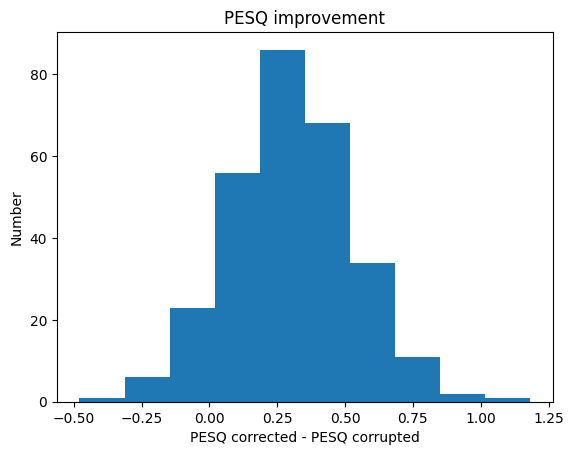

In [12]:
# Calculate and print the metrics:
def calculate_metrics(clean_signal, noisy_signal, enhanced_signal, sr=8000):
    """Calculates SNR, STOI, and PESQ metrics."""
    snr_noisy = calculate_snr(clean_signal, noisy_signal)
    snr_enhanced = calculate_snr(clean_signal, enhanced_signal)

    stoi_score = stoi(clean_signal, enhanced_signal, sr, extended=False)

    # Changed 'wb' to 'nb' for narrowband mode as sr=8000
    pesq_score = pesq(sr, clean_signal, enhanced_signal, 'nb')

    return snr_noisy, snr_enhanced, stoi_score, pesq_score

def calculate_snr(clean_signal, noisy_signal):
    """Calculates the Signal-to-Noise Ratio (SNR)."""
    # Ensure signals are NumPy arrays
    clean_signal = np.array(clean_signal)
    noisy_signal = np.array(noisy_signal)

    # Calculate the power of the clean signal
    clean_power = np.sum(clean_signal**2)

    # Calculate the power of the noise (noisy - clean)
    noise_power = np.sum((noisy_signal - clean_signal)**2)

    # Calculate SNR in dB
    snr = 10 * np.log10(clean_power / noise_power) if noise_power != 0 else float('inf') # handle division by zero

    return snr

# After processing your audio:
clean_wav = wav_clean_array[ind]  # Use actual clean audio data
wav_corrupt = wav_corrupt_array[ind]  # Use actual corrupted audio data
wav_correct = wav_correct_array[ind]  # Use actual corrected audio data
sr = 8000  # your sample rate

# Calculate and print the metrics:
snr_noisy, snr_enhanced, stoi_score, pesq_score = calculate_metrics(clean_wav, wav_corrupt, wav_correct, sr)

print(f"SNR (Noisy): {snr_noisy:.2f} dB")
print(f"SNR (Enhanced): {snr_enhanced:.2f} dB")
print(f"STOI: {stoi_score:.2f}")
print(f"PESQ: {pesq_score:.2f}")

# Visualization and saving results
os.system('rm -r val_results')
results_dir = 'val_results'
os.mkdir(results_dir)

fig = plt.figure()
plt.title('PESQ improvement')
plt.hist(pesq_diff)
plt.xlabel('PESQ corrected - PESQ corrupted')
plt.ylabel('Number')
fig.savefig(results_dir + '/pesq_hist', bbox_inches='tight')

ind = np.where(pesq_diff == pesq_diff.max())[0][0]
sf.write(results_dir + '/' + 'clean_best_pesq_improvement.wav', wav_clean_array[ind], sr)
sf.write(results_dir + '/' + 'corrupt_best_pesq_improvement.wav', wav_corrupt_array[ind], sr)
sf.write(results_dir + '/' + 'correct_best_pesq_improvement.wav', wav_correct_array[ind], sr)


0

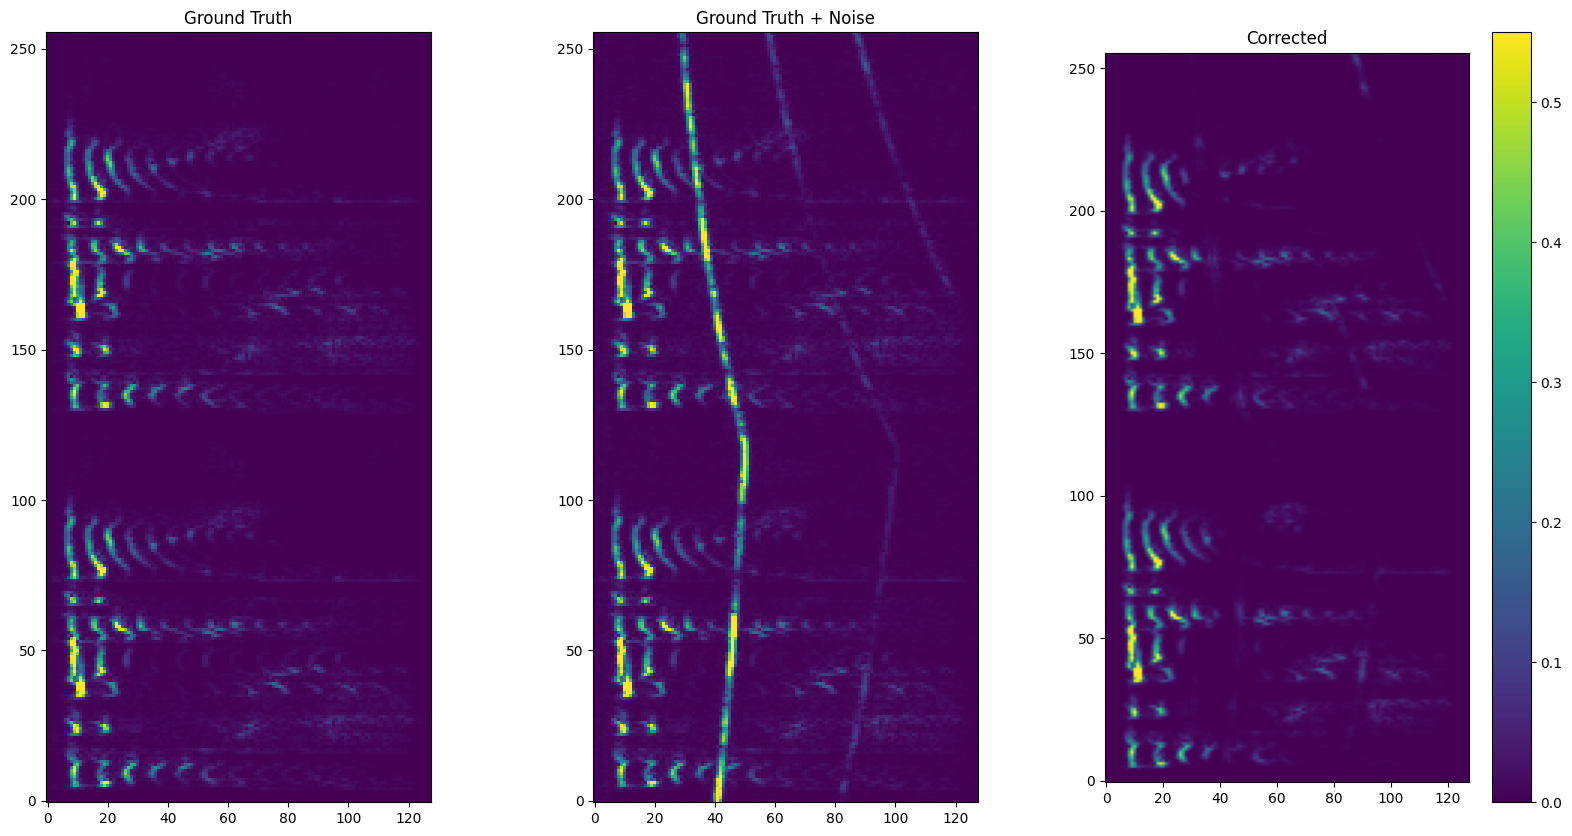

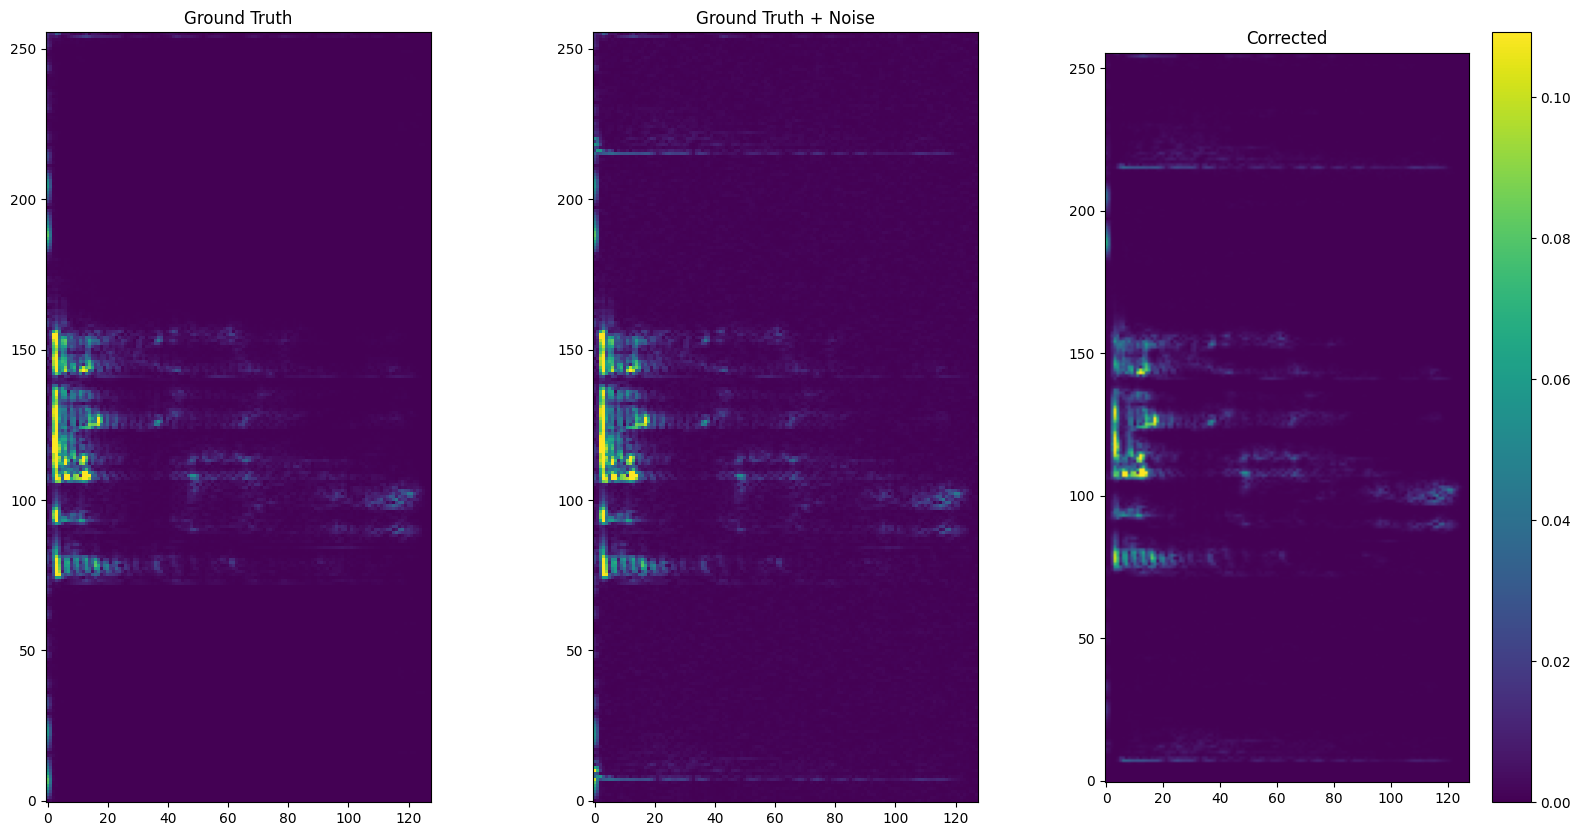

In [13]:

# Audio playback for best PESQ improvement
display(Audio(wav_clean_array[ind], rate=sr))
display(Audio(wav_corrupt_array[ind], rate=sr))
display(Audio(wav_correct_array[ind], rate=sr))

# Saving audio files for worst PESQ improvement
ind = np.where(pesq_diff == pesq_diff.min())[0][0]
sf.write(results_dir + '/' + 'clean_worst_pesq_improvement.wav', wav_clean_array[ind], sr)
sf.write(results_dir + '/' + 'corrupt_worst_pesq_improvement.wav', wav_corrupt_array[ind], sr)
sf.write(results_dir + '/' + 'correct_worst_pesq_improvement.wav', wav_correct_array[ind], sr)

# Audio playback for worst PESQ improvement
display(Audio(wav_clean_array[ind], rate=sr))
display(Audio(wav_corrupt_array[ind], rate=sr))
display(Audio(wav_correct_array[ind], rate=sr))

# Spectrogram visualization for best PESQ improvement
ind = np.where(pesq_diff == pesq_diff.max())[0][0]
fig, axes = plt.subplots(ncols=3, figsize=(20, 10))
vmax = spec_clean_array[ind].max() / 3
vmin = 0
plt.subplot(1, 3, 1)
plt.title('Ground Truth')
plt.imshow(spec_clean_array[ind], origin='lower', vmax=vmax, vmin=vmin)
plt.subplot(1, 3, 2)
plt.title('Ground Truth + Noise')
plt.imshow(spec_corrupt_array[ind], origin='lower', vmax=vmax, vmin=vmin)
plt.subplot(1, 3, 3)
plt.title('Corrected')
plt.imshow(spec_correct_array[ind], origin='lower', vmax=vmax, vmin=vmin)
plt.colorbar()
fig.savefig(results_dir + '/best_spec.png', bbox_inches='tight')

# Spectrogram visualization for worst PESQ improvement
ind = np.where(pesq_diff == pesq_diff.min())[0][0]
fig, axes = plt.subplots(ncols=3, figsize=(20, 10))
vmax = spec_clean_array[ind].max() / 3
vmin = 0
plt.subplot(1, 3, 1)
plt.title('Ground Truth')
plt.imshow(spec_clean_array[ind], origin='lower', vmax=vmax, vmin=vmin)
plt.subplot(1, 3, 2)
plt.title('Ground Truth + Noise')
plt.imshow(spec_corrupt_array[ind], origin='lower', vmax=vmax, vmin=vmin)
plt.subplot(1, 3, 3)
plt.title('Corrected')
plt.imshow(spec_correct_array[ind], origin='lower', vmax=vmax, vmin=vmin)
plt.colorbar()
fig.savefig(results_dir + '/worst_spec.png', bbox_inches='tight')

# Archiving results
os.system(f'tar -cvzf train_val_results.tar.gz {results_dir}')